# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_45743/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_45743/1200496628.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


#### Get data in pcl format and print all columns names

In [2]:
#Merge with SModelS DataFrame
# pclFiles = ['./smodels_results_slha_gchi_001.pcl', './smodels_results_48k.pcl']
pclFiles = ['../data/smodelsOutput/smodels_results_final.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900026', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'Outpu

#### Set r = 0 for points with no results 

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [4]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [5]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 21000
Total excluded (LHC) = 9780
Total allowed = 11220



#### Filter couplings

In [6]:
# gchi = extpar.1
# gq = extpar.2
# sina = extpar.3

dataDF = dataDF[((dataDF['extpar.1'] == 0.01)&(dataDF['extpar.2'] == 0.1))|((dataDF['extpar.1'] == 0.01)&(dataDF['extpar.2'] == 0.15))]

### Get all analyses in one column

In [7]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c and not 'weights' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID', 'ExptRes.result6.AnalysisID', 'ExptRes.result7.AnalysisID', 'ExptRes.result8.AnalysisID']


In [8]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [9]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [10]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            # resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
            #                                                            or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            resCols = [idc for idc in idCols if (row[idc] == anaID)]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [11]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [12]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

,ExptRes.result.AnalysisID,ExptRes.result.TxNames,ExptRes.result.r
0,ATLAS-EXOT-2019-03,[TRV1jj],3.760189
1,ATLAS-EXOT-2019-03,[TRV1jj],3.760189
2,ATLAS-EXOT-2019-03,[TRV1jj],3.760189
3,ATLAS-EXOT-2019-03,[TRV1jj],3.760189
4,ATLAS-EXOT-2019-03,[TRV1jj],3.760189
...,...,...,...
201013,ATLAS-SUSY-2018-22,[TRV1],0.000067
201014,ATLAS-SUSY-2018-22,[TRV1],0.000067
201015,ATLAS-SUSY-2018-22,[TRV1],0.000067
201016,ATLAS-SUSY-2018-22,[TRV1],0.000067


In [13]:
# select only resonances searches
allAnas = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-12-059', 'ATLAS-EXOT-2018-48', 'CMS-EXO-19-012', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']

In [14]:
# newDF = newDF[newDF['ExptRes.result.AnalysisID'].isin(dijAnas)]
newDF = newDF[newDF['ExptRes.result.AnalysisID'].isin(allAnas)]

In [15]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)


In [16]:
excluded['ExptRes.result.AnalysisID'].unique()

array(['ATLAS-EXOT-2019-03', 'CMS-EXO-20-008', 'CMS-EXO-16-057',
       'CMS-EXO-19-012', 'ATLAS-EXOT-2018-48', 'ATLAS-EXOT-2013-11'],
      dtype=object)

#### Create legend for plots for excluded points

In [17]:
colors = sns.color_palette("hls",len(newDF['ExptRes.result.AnalysisID'].unique()))


In [18]:
colorDict = {}

for i, l in enumerate(newDF['ExptRes.result.AnalysisID'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [19]:
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=ana)
    legend.append(l)

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

In [20]:
newDF['extpar.2'].unique()

array([0.1 , 0.15])

In [21]:
newDF['extpar.1'].unique()

array([0.01])

In [22]:
colorDict

{'ATLAS-EXOT-2019-03': array([[0.86  , 0.3712, 0.34  ]]),
 'ATLAS-EXOT-2013-11': array([[0.86      , 0.81691429, 0.34      ]]),
 'CMS-EXO-12-059': array([[0.45737143, 0.86      , 0.34      ]]),
 'ATLAS-EXOT-2018-48': array([[0.34      , 0.86      , 0.66834286]]),
 'CMS-EXO-19-012': array([[0.34      , 0.60594286, 0.86      ]]),
 'CMS-EXO-20-008': array([[0.51977143, 0.34      , 0.86      ]]),
 'CMS-EXO-16-057': array([[0.86      , 0.34      , 0.75451429]])}

CMS-EXO-16-057
CMS-EXO-19-012


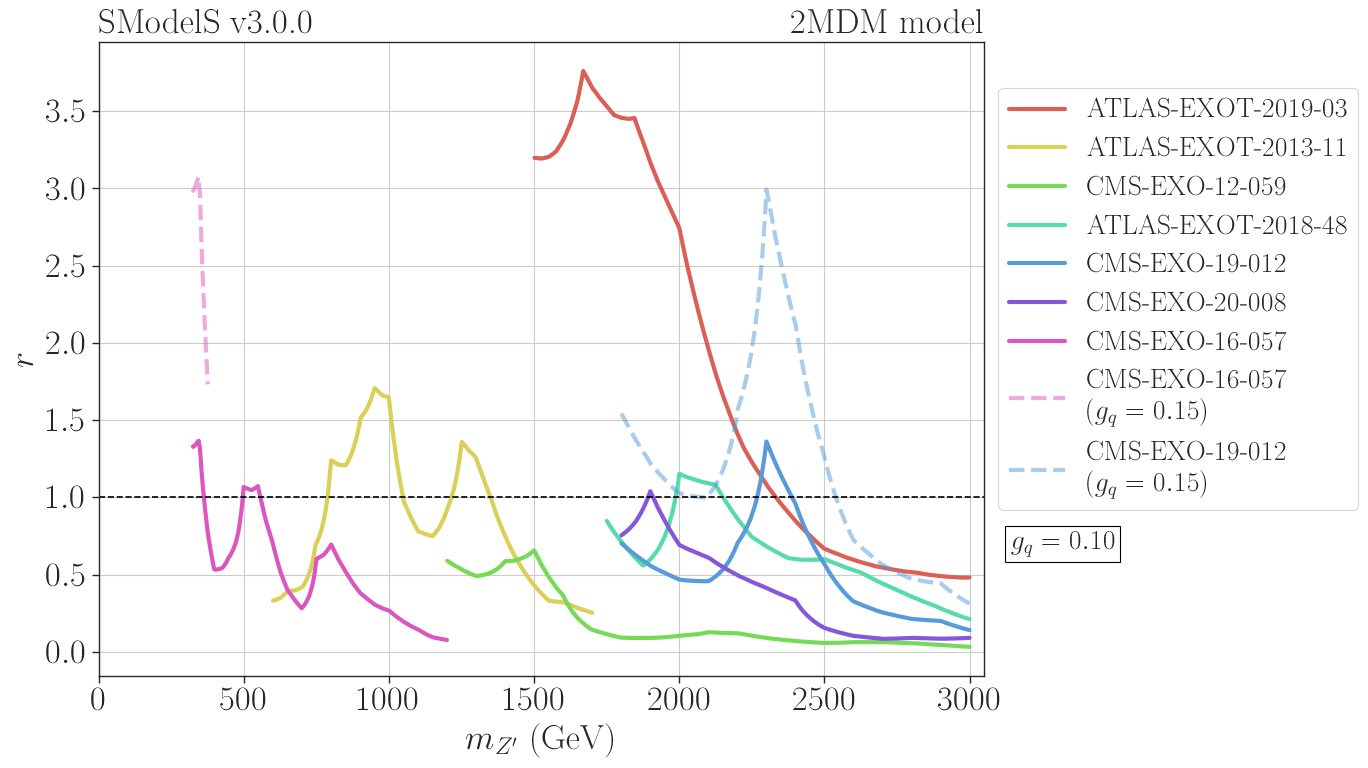

In [58]:
cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(14,8))

gqv = 0.10
gchi = 0.01


for label in newDF['ExptRes.result.AnalysisID'].unique():
#     if 'CMS-EXO-19-012' not in label: continue
    data = newDF[newDF['ExptRes.result.AnalysisID']==label]
    data = data[(data['extpar.1']==gchi)&(data['extpar.2']==gqv)].sort_values(['mass.9900032'])
#     print(label)
    
    if len(data) == 0: continue
    x = data['mass.9900032']
    y = data['ExptRes.result.r']

    pl = plt.plot(x, y, '-', lw=3., label=label, c=colorDict[label])
    
    # sc = plt.scatter(x,y,s=10, label=label, c=colorDict[label])

data2 = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==0.15)].sort_values(['mass.9900032'])

for label in data2['ExptRes.result.AnalysisID'].unique():
    print(label)
    if len(data2) == 0: continue
    data3 = data2[data2['ExptRes.result.AnalysisID'] == label]
    x = data3['mass.9900032']
    y = data3['ExptRes.result.r']

    pl2 = plt.plot(x, y, '--', lw=3., label=label+'\n'+r' ($g_{q} = %1.2f$)' %(0.15), c=colorDict[label], alpha=0.5)

    # sc2 = plt.scatter(x,y,s=10, label=label, c=colorDict[label], alpha=0.5, marker=',')
    

plt.hlines(1, 0, 3050, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$r$', fontsize=25)
plt.text(1.03 ,0.2,r'$g_{q} = %1.2f$' %(gqv),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

plt.xlim(0, 3050)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.legend(bbox_to_anchor=(1, 0.95), fontsize=20)
plt.tight_layout()
plt.grid()

plt.savefig('./figures/exclusions_2mdm_resonance.png')
plt.show()


In [24]:
# separate between dijet and the rest
dijAnas = ['ATLAS-EXOT-2019-03', 'CMS-EXO-19-012', 'CMS-EXO-12-059', 'ATLAS-EXOT-2013-11']
otherAnas = ['ATLAS-EXOT-2018-48', 'CMS-EXO-20-008', 'CMS-EXO-16-057']

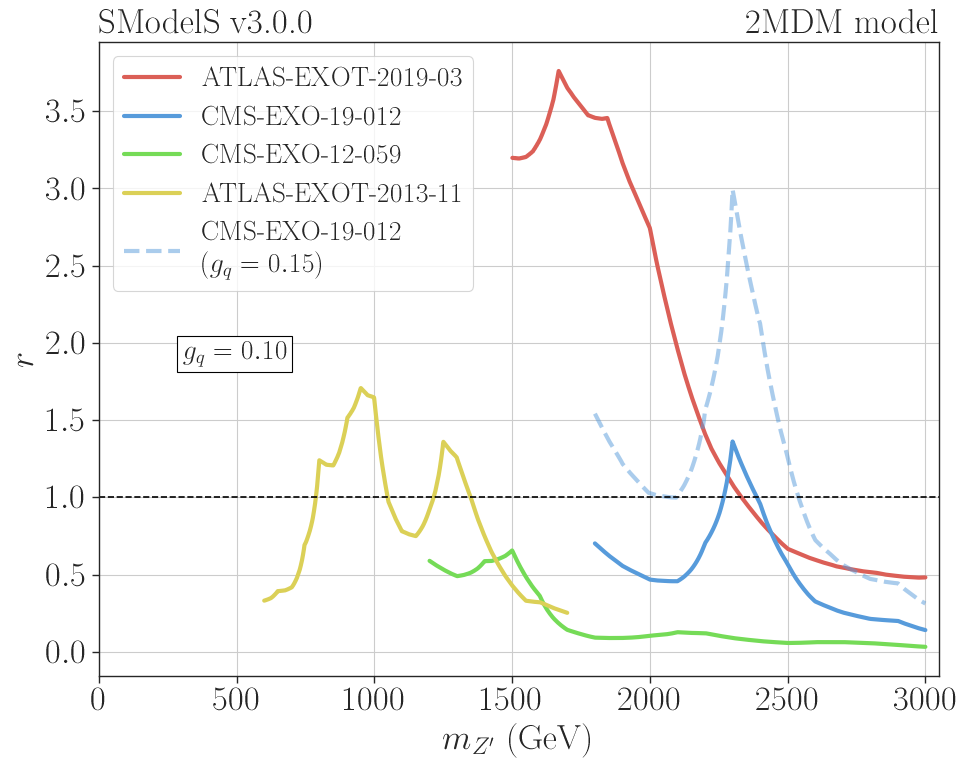

In [59]:
cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

gqv = 0.10
gchi = 0.01


for label in dijAnas:
#     if 'CMS-EXO-19-012' not in label: continue
    data_nwa = newDF[newDF['ExptRes.result.AnalysisID']==label]
    data_nwa = data_nwa[(data_nwa['extpar.1']==gchi)&(data_nwa['extpar.2']==gqv)].sort_values(['mass.9900032'])
#     print(label)
    
    if len(data_nwa) == 0: continue
    x = data_nwa['mass.9900032']
    y = data_nwa['ExptRes.result.r']

    pl = plt.plot(x, y, '-', lw=3., label=label, c=colorDict[label])
    
    # sc = plt.scatter(x,y,s=10, label=label, c=colorDict[label])

data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==0.15)].sort_values(['mass.9900032'])

for label in dijAnas:
    # if len(data2) == 0: continue
    data_wide = data[data['ExptRes.result.AnalysisID'] == label]
    x = data_wide['mass.9900032']
    y = data_wide['ExptRes.result.r']
    if (len(x) == 0): continue

    pl2 = plt.plot(x, y, '--', lw=3., label=label+'\n'+r'($g_{q} = %1.2f$)' %(0.15), c=colorDict[label], alpha=0.5)

    # sc2 = plt.scatter(x,y,s=10, label=label, c=colorDict[label], alpha=0.5, marker=',')
    

plt.hlines(1, 0, 3050, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$r$', fontsize=25)
plt.text(0.1,0.5,r'$g_{q} = %1.2f$' %(gqv),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

plt.xlim(0, 3050)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.legend(loc='upper left', fontsize=20)
plt.tight_layout()
plt.grid()

plt.savefig('./figures/exclusions_2mdm_diquark.png')
plt.show()

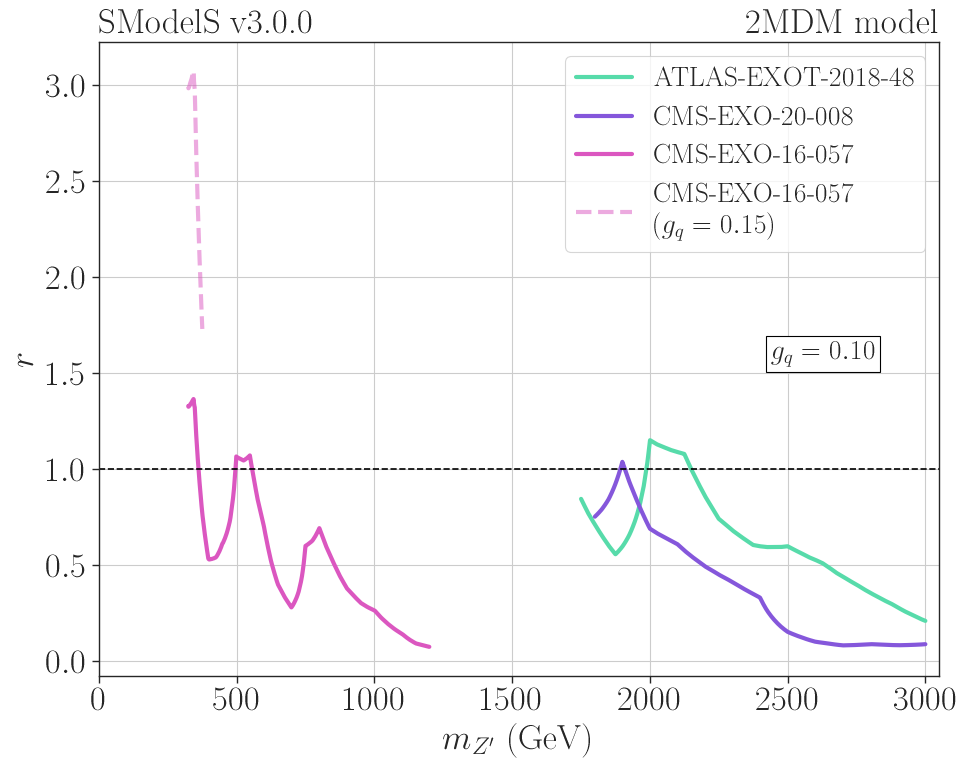

In [60]:
cm = plt.colormaps.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(10,8))

gqv = 0.10
gchi = 0.01


for label in otherAnas:
#     if 'CMS-EXO-19-012' not in label: continue
    data_nwa = newDF[newDF['ExptRes.result.AnalysisID']==label]
    data_nwa = data_nwa[(data_nwa['extpar.1']==gchi)&(data_nwa['extpar.2']==gqv)].sort_values(['mass.9900032'])
#     print(label)
    
    if len(data_nwa) == 0: continue
    x = data_nwa['mass.9900032']
    y = data_nwa['ExptRes.result.r']

    pl = plt.plot(x, y, '-', lw=3., label=label, c=colorDict[label])
    
    # sc = plt.scatter(x,y,s=10, label=label, c=colorDict[label])

data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==0.15)].sort_values(['mass.9900032'])

for label in otherAnas:
    # if len(data2) == 0: continue
    data_wide = data[data['ExptRes.result.AnalysisID'] == label]
    x = data_wide['mass.9900032']
    y = data_wide['ExptRes.result.r']
    if (len(x) == 0): continue

    pl2 = plt.plot(x, y, '--', lw=3., label=label+'\n'+r'($g_{q} = %1.2f$)' %(0.15), c=colorDict[label], alpha=0.5)

    # sc2 = plt.scatter(x,y,s=10, label=label, c=colorDict[label], alpha=0.5, marker=',')
    

plt.hlines(1, 0, 3050, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$r$', fontsize=25)
plt.text(0.8,0.5,r'$g_{q} = %1.2f$' %(gqv),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

plt.xlim(0, 3050)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)

plt.legend(loc='upper right', fontsize=20)
plt.tight_layout()
plt.grid()

plt.savefig('./figures/exclusions_2mdm_resonances_trimmed.png')
plt.show()

In [26]:
newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==0.15)].sort_values(['mass.9900032'])

,filename,mass.9000006,mass.9900026,mass.9900032,mass.9000002,mass.9000003,mass.9000004,mass.9000005,width.9000002,width.9000003,...,ExptRes.result.TxNames weights (fb).TRS1,ExptRes.result.nll,ExptRes.result.nll_min,ExptRes.result.nll_SM,ExptRes.result.TxNames weights (fb).TRV1,ExptRes.result.TxNames weights (fb).TRV1qq,ExptRes.result.TxNames weights (fb).TRV1bb,excludedLHC,ExptRes.result.TxNames weights (fb).TRV1tt,excluded
22315,scan_3_mh15q9ad.slha,65.0,161.9773,323.9547,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,39065.54602,True,NaN,True
22316,scan_3_mh15q9ad.slha,65.0,161.9773,323.9547,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,39065.54602,True,NaN,True
22317,scan_3_mh15q9ad.slha,65.0,161.9773,323.9547,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,39065.54602,True,NaN,True
22318,scan_3_mh15q9ad.slha,65.0,161.9773,323.9547,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,39065.54602,True,NaN,True
22319,scan_3_mh15q9ad.slha,65.0,161.9773,323.9547,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,39065.54602,True,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160218,scan_3_0zacjj39.slha,65.0,1500.0000,3000.0000,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
160219,scan_3_0zacjj39.slha,65.0,1500.0000,3000.0000,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
160220,scan_3_0zacjj39.slha,65.0,1500.0000,3000.0000,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False
160221,scan_3_0zacjj39.slha,65.0,1500.0000,3000.0000,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,False


In [61]:
y

Series([], Name: ExptRes.result.r, dtype: float64)

In [24]:
newDF

,filename,mass.9000006,mass.9900026,mass.9900032,mass.9000002,mass.9000003,mass.9000004,mass.9000005,width.9000002,width.9000003,...,ExptRes.result.lumi (fb-1),ExptRes.result.dataType,ExptRes.result.r,ExptRes.result.r_expected,ExptRes.result.Width (GeV),ExptRes.result.nll,ExptRes.result.nll_min,ExptRes.result.nll_SM,excludedLHC,excluded
0,scan_3_xfrks_2q.slha,65.0,834.4148,1668.83,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,139.0,upperLimit,3.760189,2.566468,"[(zp, 7.9694)]",NaN,NaN,NaN,True,True
1,scan_3_xfrks_2q.slha,65.0,834.4148,1668.83,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,139.0,upperLimit,3.760189,2.566468,"[(zp, 7.9694)]",NaN,NaN,NaN,True,True
2,scan_3_xfrks_2q.slha,65.0,834.4148,1668.83,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,139.0,upperLimit,3.760189,2.566468,"[(zp, 7.9694)]",NaN,NaN,NaN,True,True
3,scan_3_xfrks_2q.slha,65.0,834.4148,1668.83,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,139.0,upperLimit,3.760189,2.566468,"[(zp, 7.9694)]",NaN,NaN,NaN,True,True
4,scan_3_xfrks_2q.slha,65.0,834.4148,1668.83,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,139.0,upperLimit,3.760189,2.566468,"[(zp, 7.9694)]",NaN,NaN,NaN,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160195,scan_3_0zacjj39.slha,65.0,1500.0000,3000.00,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,137.0,upperLimit,0.312589,-1.000000,"[(zp, 32.232)]",NaN,NaN,NaN,False,False
160196,scan_3_0zacjj39.slha,65.0,1500.0000,3000.00,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,137.0,upperLimit,0.312589,-1.000000,"[(zp, 32.232)]",NaN,NaN,NaN,False,False
160197,scan_3_0zacjj39.slha,65.0,1500.0000,3000.00,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,137.0,upperLimit,0.312589,-1.000000,"[(zp, 32.232)]",NaN,NaN,NaN,False,False
160198,scan_3_0zacjj39.slha,65.0,1500.0000,3000.00,91.1876,79.82436,79.82436,1500.0,2.4952,2.085,...,137.0,upperLimit,0.312589,-1.000000,"[(zp, 32.232)]",NaN,NaN,NaN,False,False
